# Part 1 - image segmentation 

In [1]:
# Installed scikit-video (skvideo) and ffmpeg from conda
# https://anaconda.org/conda-forge/sk-video
# https://anaconda.org/conda-forge/ffmpeg

import skvideo.io
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from skimage.measure import label, regionprops
from skimage import morphology
from skimage.color import label2rgb
from skimage.exposure import histogram
from skimage.feature import canny
from skimage.filters import sobel, threshold_otsu, threshold_local
from skimage.segmentation import watershed

from ipywidgets import interact

from tqdm import tqdm

# Import video to frames
file_name = 'laser.mp4'
frames = skvideo.io.vread(file_name, as_grey = True)

# Check the size of the loaded data
frames.shape

(200, 500, 1024, 1)

Define functions for inspecting the data and perform background corrections

In [4]:
def frame_generator(frames, frame_number, background = 19, cropv = (105, 300), croph = (None, None), takelog = True):
    '''
    frames: array containing all frames
    frame_number: specific frame to be returned
    background: background frame
    cropv: vertical crop (start, end)
    croph: horizontal crop (start, end)
    takelog: take the log of the frame
    '''
    
    image = frames[frame_number].squeeze() + 0.01 # Add 0.01 to avoid zero division
    background = frames[background].squeeze() + 0.01
    if takelog == True:
        image = np.log(image) - np.log(background) # Subtract background
    else:
        image = image - background
    image = image[cropv[0]:cropv[1], croph[0]:croph[1]] # Crop image if necessary
    return image

In [5]:
def frame_plotter(frames, frame_number, background = 19, cropv = (105, 300), croph = (None, None)):
    '''
    Passes arguments to frame_generator and plots the frame
    '''

    image = frame_generator(frames, frame_number, background, cropv, croph)
    # Plot the image
    fig, axes = plt.subplots(1, 1, figsize = (15,10))
    im1 = axes.imshow(image)
    fig.colorbar(im1, shrink = 0.2)
    plt.show()

Find a good background frame with interactive plot

In [6]:
@interact
def show_frame(frame_number=(0, len(frames)-1, 1), background = (0, len(frames)-1, 1)):
    frame_plotter(frames, frame_number, background=background, cropv = (None, None))


interactive(children=(IntSlider(value=99, description='frame_number', max=199), IntSlider(value=99, descriptio…

https://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html for background on the segmentation code

Look at the histogram to see if thresholding alone is sufficient to segment the regions.

Here, the doesn't appear to be a clear separation.

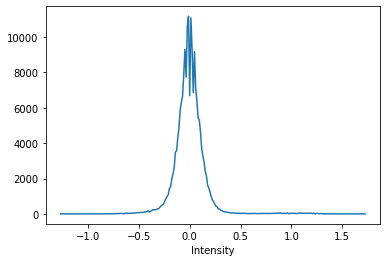

In [7]:
# Plot the intensity histogram
image = frame_generator(frames, 181, background = 19, cropv = (105, 300), croph = (None, None))
hist, hist_centers = histogram(image)
plt.plot(hist_centers, hist)
plt.xlabel('Intensity')
plt.show()

Widget to look at manual thresholding

In [8]:
@interact
def thresholding(th_low = (-0.7, 0.7, 0.1), th_high = (-0.7, 0.7, 0.1)):
    markers = np.zeros_like(image)
    markers[image < th_low] = 1
    markers[image > th_high] = 2

    plt.figure(figsize = (15,10))
    plt.imshow(markers)
    plt.colorbar(shrink = 0.2)

interactive(children=(FloatSlider(value=-0.09999999999999987, description='th_low', max=0.7, min=-0.7), FloatS…

Test edge-based segmentation
Note - canny detector does not work well with the logs so use normal intensities

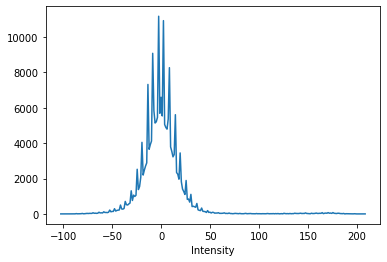

In [9]:
# Generate non-log image
image = frame_generator(frames, 181, background = 19, cropv = (105, 300), croph = (None, None), takelog = False)
# Plot the intensity histogram
hist, hist_centers = histogram(image)
plt.plot(hist_centers, hist)
plt.xlabel('Intensity')
plt.show()

In [10]:
@interact
def canny_detect(factor = (0, 1000, 1), sigma = (0,2,0.1), fill = (0, 1, 1)):
    edges = canny(image/factor, sigma = sigma)
    if fill:
        edges = ndi.binary_fill_holes(edges)
    plt.figure(figsize = (15,10))
    plt.imshow(edges)
    # plt.colorbar(shrink = 0.2)

interactive(children=(IntSlider(value=500, description='factor', max=1000), FloatSlider(value=1.0, description…

Test gradient-based segmentation using manual thresholding, sobel edge detector and watershed function.

Use this to set parameters for batch processing

In [11]:
@interact(
    frame_number = (0, len(frames)-1, 1), 
    th_low = (-70, 70, 1), 
    th_high = (-70, 70, 1), 
    segmentation = True,
    fill = True, 
    original = True,
    opacity = (0, 1, 0.1),
    remove_small = True,
    min_size = (0, 60, 1))

def manual_thresholding(
        frame_number = 181, 
        th_low = -52, 
        th_high = 12, 
        segmentation = True, 
        fill = True, 
        original = True,
        opacity = 0.3,
        remove_small = True, 
        min_size = 37,
        plot = True,
        do_return = False):
    image = frame_generator(frames, frame_number, background = 19, cropv = (105, 300), croph = (None, None), takelog = False)
    edges = sobel(image)
    markers = np.zeros_like(edges)
    markers[image < th_low] = 2
    markers[image > th_high] = 1
    out = markers
    if segmentation:
        out = watershed(edges, markers)
    if fill:
        out = ndi.binary_fill_holes(out-1)
    if remove_small:
        out = morphology.remove_small_objects(out, min_size=min_size)
    
    if plot:
        plt.figure(figsize = (15,10))
        if original:
            plt.imshow(image)
        plt.imshow(out, alpha = opacity)
        plt.colorbar(shrink = 0.2)
    if do_return:
        return out

interactive(children=(IntSlider(value=181, description='frame_number', max=199), IntSlider(value=-52, descript…

Test of local thresholding - as illumination is quite even, this doesn't give much improvement

In [144]:
@interact(
    frame_number = (0, len(frames)-1, 1), 
    block_size = (1, 99, 2),
    offset = (0, 100, 1),
    segmentation = True, 
    fill = True, 
    original = True,
    opacity = (0, 1, 0.1),
    remove_small = True,
    min_size = (0, 20, 1))

def auto_thresholding(
        frame_number = 181, 
        block_size = 31,
        offset = 10,
        segmentation = True, 
        fill = True, 
        original = True,
        opacity = 1,
        remove_small = True, 
        min_size = 10):
    image = frame_generator(frames, frame_number, background = 19, cropv = (105, 300), croph = (None, None), takelog = False)
    markers = np.zeros_like(sobel(image))
    local_thresh = threshold_local(image, block_size=block_size, offset=offset)
    markers[image < local_thresh] = 2
    markers[image > local_thresh] = 1
    out = markers
    if segmentation:
        out = watershed(sobel(image), markers)
    if fill:
        out = ndi.binary_fill_holes(out-1)
    if remove_small:
        out = morphology.remove_small_objects(out, min_size=min_size)
    
    plt.figure(figsize = (15,10))
    if original:
        plt.imshow(image)
    plt.imshow(out, alpha = opacity)
    plt.colorbar(shrink = 0.2)
    # return out

interactive(children=(IntSlider(value=181, description='frame_number', max=199), IntSlider(value=31, descripti…

Generate a video of the segmented frames for tracking

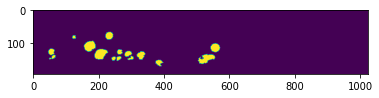

In [13]:
# Test a single frame
out = manual_thresholding(
        frame_number = 181, 
        th_low = -52, 
        th_high = 12, 
        segmentation = True, 
        fill = True, 
        original = True,
        opacity = 0.3,
        remove_small = True, 
        min_size = 37,
        plot = False,
        do_return = True)

plt.imshow(out)

Default parameters have been set for this specific dataset

In [14]:
segmented_frames = []
for i in tqdm(range(frames.shape[0])):
    segmented_frames.append(manual_thresholding(frame_number = i, plot = False, do_return = True))

100%|██████████| 200/200 [00:10<00:00, 18.44it/s]


Convert to array

In [18]:
segmented_frames = np.array(segmented_frames)

Write a video of the segmented regions

In [32]:
skvideo.io.vwrite('segmented.mp4', segmented_frames.astype(np.uint8)*255)

# Part 2 - Object tracking
See here for in-depth discussion: http://soft-matter.github.io/trackpy/v0.5.0/tutorial/walkthrough.html

In [33]:
import trackpy as tp

Use trackpy to locate particles and plot

In [37]:
@interact
def track_plot(frame_number=(0, len(frames)-1, 1), mass = (1, 101, 2)):
    f = tp.locate(segmented_frames[frame_number], mass)
    tp.annotate(f, segmented_frames[frame_number])

interactive(children=(IntSlider(value=99, description='frame_number', max=199), IntSlider(value=51, descriptio…

Explore the attributes of the tp.locate object generated. Note - mass indicated total brightness

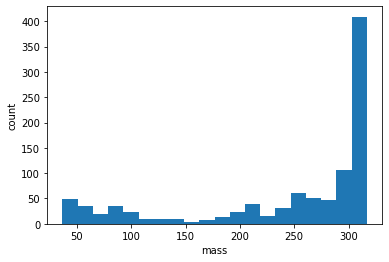

In [38]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)
ax.set(xlabel='mass', ylabel='count');

Now locate features in every frame

In [39]:
f = tp.batch(segmented_frames, 21)

Frame 199: 0 features


Link features to particle trajectories. Tune memory etc. to get cleaner data

In [40]:
t = tp.link(f, 10, memory=3)

Frame 198: 12 trajectories present.


In [41]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,40.247539,430.182487,94.393623,4.590559,0.234809,0.999891,95.0,0.0,10,0
1,65.908628,804.998211,56.604064,3.879054,0.126239,0.993122,57.0,0.0,11,1
2,159.948836,32.474858,39.702541,3.068784,0.210301,0.990427,40.0,0.0,23,2
3,68.858248,503.744159,77.539530,3.958046,0.088891,0.999928,78.0,0.0,24,3
4,136.751272,956.940457,51.631587,3.534669,0.159115,0.992086,52.0,0.0,24,4


Filter spurious short-lived trajectories (tune minimum number of frames that a trajectory survives for)

In [45]:
t1 = tp.filter_stubs(t, 5)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 396
After: 22


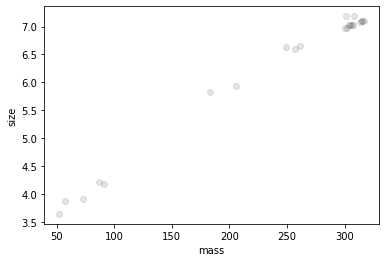

In [46]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

Filter out spurious particles by shape

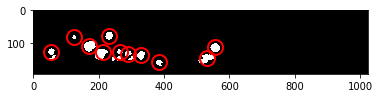

<AxesSubplot:>

In [47]:
t2 = t1[((t1['mass'] > 20) & (t1['size'] < 10) &
         (t1['ecc'] < 0.3))]

plt.figure()
frame_number = 181
tp.annotate(t2[t2['frame'] == frame_number], segmented_frames[frame_number])

Plot the trajectories

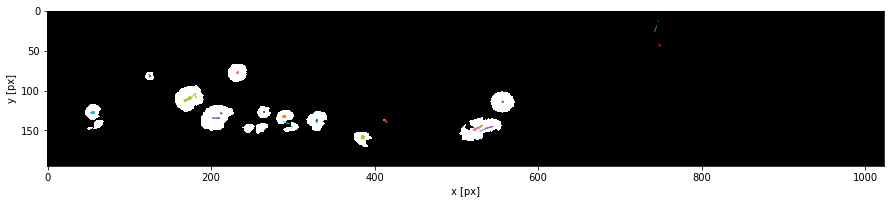

In [53]:
# Get aspect ratio
aspect = segmented_frames.shape[1] / segmented_frames.shape[2]

# Overlay particle trajectories
fig, ax = plt.subplots(1, 1, figsize=(15,15*aspect))
tp.plot_traj(t2, superimpose=segmented_frames[frame_number], ax=ax)
ax.set_aspect('auto')

# 3. To do

Test tracking with the raw image - perhaps segmentation is not needed if the raw images can be cleverly preprocessed?

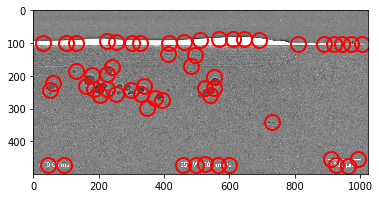

<AxesSubplot:>

In [54]:
f = tp.locate(frames[181].squeeze(), 21, minmass=1000)
tp.annotate(f, frames[181].squeeze())

Use histogram to determine cutoff?

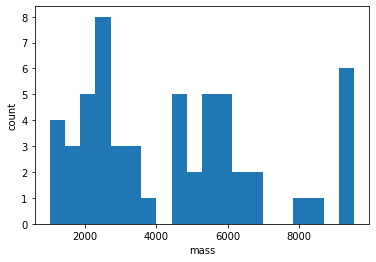

In [55]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)
ax.set(xlabel='mass', ylabel='count');